In [8]:
%cd /Users/Kunal/Projects/TCH_CardiacSignals_F20/

/Users/kunal/Projects/TCH_CardiacSignals_F20


In [1]:
from numpy.random import seed
seed(1)
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow
tensorflow.random.set_seed(2)
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Dropout, Conv1D, MaxPooling1D, BatchNormalization, UpSampling1D, Conv1DTranspose
from tensorflow.keras.models import Sequential, Model
from src.preprocess.dim_reduce.patient_split import *
from src.preprocess.heartbeat_split import heartbeat_split
from sklearn.model_selection import train_test_split

In [2]:
def read_in(file_index, normalized, train, ratio):
    """
    Reads in a file and can toggle between normalized and original files
    :param file_index: patient number as string
    :param normalized: binary that determines whether the files should be normalized or not
    :param train: int that determines whether or not we are reading in data to train the model or for encoding
    :param ratio: ratio to split the files into train and test
    :return: returns npy array of patient data across 4 leads
    """
    # filepath = os.path.join("Working_Data", "Normalized_Fixed_Dim_HBs_Idx" + file_index + ".npy")
    # filepath = os.path.join("Working_Data", "1000d", "Normalized_Fixed_Dim_HBs_Idx35.npy")
    filepath = "Working_Data/Training_Subset/Normalized/two_hbs/Normalized_Fixed_Dim_HBs_Idx" + str(file_index) + ".npy"

    if normalized == 1:
        if train == 1:
            normal_train, normal_test, abnormal = patient_split_train(filepath, ratio)
            # noise_factor = 0.5
            # noise_train = normal_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=normal_train.shape)
            return normal_train, normal_test
        elif train == 0:
            training, test, full = patient_split_all(filepath, ratio)
            return training, test, full
        elif train == 2:
            train_, test, full = patient_split_all(filepath, ratio)
            noise_factor = 0.5
            noise_train = train_ + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_.shape)
            return train_, noise_train, test, full
    else:
        data = np.load(os.path.join("Working_Data", "Fixed_Dim_HBs_Idx" + file_index + ".npy"))
        return data

In [4]:
def build_model(sig_shape, encode_size):
    """
    Builds a deterministic autoencoder model, returning both the encoder and decoder models
    :param sig_shape: shape of input signal
    :param encode_size: dimension that we want to reduce to
    :return: encoder, decoder models
    """
    encoder = Sequential()
    encoder.add(InputLayer(sig_shape))
    encoder.add(Flatten())
    encoder.add(Dense(200, activation='tanh', kernel_initializer='glorot_normal'))
    encoder.add(Dense(125, activation='relu', kernel_initializer='glorot_normal'))
    encoder.add(Dense(100, activation='relu', kernel_initializer='glorot_normal'))
    encoder.add(Dense(50, activation='relu', kernel_initializer='glorot_normal'))
    encoder.add(Dense(25, activation='relu', kernel_initializer='glorot_normal'))
    encoder.add(Dense(encode_size))

    # Decoder
    decoder = Sequential()
    decoder.add(InputLayer((encode_size,)))
    decoder.add(Dense(25, activation='relu', kernel_initializer='glorot_normal'))
    decoder.add(Dense(50, activation='relu', kernel_initializer='glorot_normal'))
    decoder.add(Dense(100, activation='relu', kernel_initializer='glorot_normal'))
    decoder.add(Dense(125, activation='relu', kernel_initializer='glorot_normal'))
    decoder.add(Dense(200, activation='tanh', kernel_initializer='glorot_normal'))
    decoder.add(Dense(np.prod(sig_shape), activation='linear'))
    decoder.add(Reshape(sig_shape))

    return encoder, decoder

In [10]:
def training_ae(num_epochs, reduced_dim, file_index):
    """
    Training function for deterministic autoencoder model, saves the encoded and reconstructed arrays
    :param num_epochs: number of epochs to use
    :param reduced_dim: goal dimension
    :param file_index: patient number
    :return: None
    """
    normal, abnormal, all = read_in(file_index, 1, 0, 0.3)
    normal_train = normal[:round(len(normal)*.85),:]
    normal_valid = normal[round(len(normal)*.85):,:]
    signal_shape = normal.shape[1:]
    batch_size = round(len(normal) * 0.1)

    encoder, decoder = build_model(signal_shape, reduced_dim)

    encode = encoder(Input(signal_shape))
    reconstruction = decoder(encode)

    inp = Input(signal_shape)
    encode = encoder(inp)
    reconstruction = decoder(encode)

    autoencoder = Model(inp, reconstruction)
    opt = keras.optimizers.Adam(learning_rate=0.0008)
    autoencoder.compile(optimizer=opt, loss='mse')

    early_stopping = EarlyStopping(patience=10, min_delta=0.0001, mode='min')
    autoencoder = autoencoder.fit(x=normal_train, y=normal_train, epochs=num_epochs, validation_data=(normal_valid, normal_valid), batch_size=batch_size, callbacks=early_stopping)

    plt.plot(autoencoder.history['loss'])
    plt.plot(autoencoder.history['val_loss'])
    plt.title('model loss patient' + str(file_index))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # save out the model
    # filename = 'ae_patient_' + str(file_index) + '_dim' + str(reduced_dim) + '_model'
    # autoencoder.save(filename + '.h5')
    # print('Model saved for ' + 'patient ' + str(file_index))

    # using AE to encode other data
    # encoded = encoder.predict(all)
    # reconstruction = decoder.predict(encoded)

    # save reconstruction, encoded, and input if needed
    # reconstruction_save = os.path.join("Working_Data", "reconstructed_ae_" + str(reduced_dim) + "d_Idx" + str(file_index) + ".npy")
    # encoded_save = os.path.join("Working_Data", "reduced_ae_" + str(reduced_dim) + "d_Idx" + str(file_index) + ".npy")

    # reconstruction_save = "Working_Data/Training_Subset/Model_Output/reconstructed_2hb_" + str(file_index) + ".npy"
    # encoded_save = "Working_Data/Training_Subset/Model_Output/encoded_2hb_" + str(file_index) + ".npy"
    #
    # np.save(reconstruction_save, reconstruction)
    # np.save(encoded_save,encoded)

    # if training and need to save test split for MSE calculation
    # input_save = os.path.join("Working_Data","1000d", "original_data_test_ae" + str(100) + "d_Idx" + str(35) + ".npy")
    # np.save(input_save, test)

In [6]:
def run(num_epochs, encoded_dim):
    """
    Run training autoencoder over all dims in list
    :param num_epochs: number of epochs to train for
    :param encoded_dim: dimension to run on
    :return None, saves arrays for reconstructed and dim reduced arrays
    """
    for patient_ in [1,16,4,11]: #heartbeat_split.indicies:
        print("Starting on index: " + str(patient_))
        training_ae(num_epochs, encoded_dim, patient_)
        print("Completed " + str(patient_) + " reconstruction and encoding, saved test data to assess performance")



Starting on index: 1
Epoch 1/100
9/9 [==============================] - 0s 44ms/step - loss: 0.9326 - val_loss: 0.6699
Epoch 2/100
9/9 [==============================] - 0s 27ms/step - loss: 0.4018 - val_loss: 0.2913
Epoch 3/100
9/9 [==============================] - 0s 24ms/step - loss: 0.1563 - val_loss: 0.2558
Epoch 4/100
9/9 [========

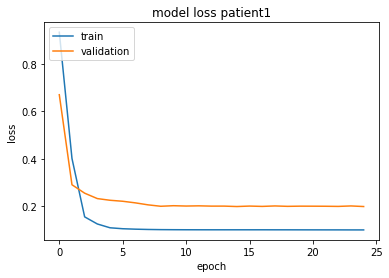

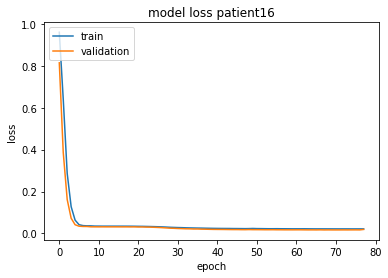

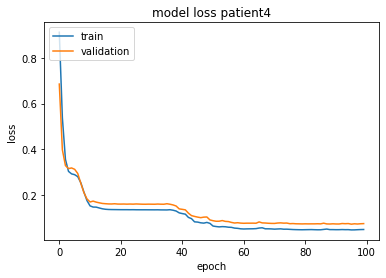

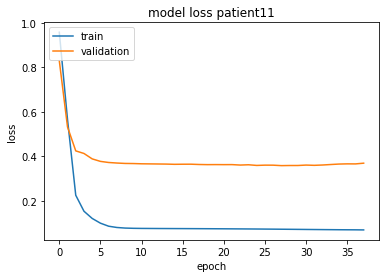

In [11]:
#################### Training to be done for 100 epochs for all dimensions ############################################
run(100, 1)

# run(100,100)